In [1]:
cd /home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/

/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster


/home/ildefonso/Documents/repos/vocalpy/Nicholson-Cohen-SfN-2023-poster/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_csv('./results/summary-data-loss-function-experiments.csv')

In [4]:
def condition(row):
    loss = row['Loss']
    postprocess = row['Post-processing']
    condition_str = f'Loss: {loss}'
    if postprocess:
        condition_str += ' with clean-ups'
    return condition_str

In [5]:
@dataclass
class MetricPlot:
    metric: str
    ascending: bool
    ylim: list[int]
    save_fname: str
    legend_loc: str

In [6]:
metrics_plots = (
    MetricPlot(
        metric='Frame Error (%)',
        ascending=True,
        ylim=[0., 1.8],
        save_fname='loss-frame-error',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='Character Error Rate (%)',
        ascending=True,
        ylim=[0., 28.],
        save_fname='loss-character-error-rate',
        legend_loc='upper right',
    ),
    MetricPlot(
        metric='Precision (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='loss-precision',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='Recall (%)',
        ascending=False,
        ylim=[80, 100],
        save_fname='loss-recall',
        legend_loc='lower right',
    ),
    MetricPlot(
        metric='$F$-score (%)',
        ascending=False,
        ylim=[92.5, 100],
        save_fname='loss-fscore',
        legend_loc='upper left',
    ),
)

In [7]:
sns.set()
sns.set_context('poster', font_scale=1.5)

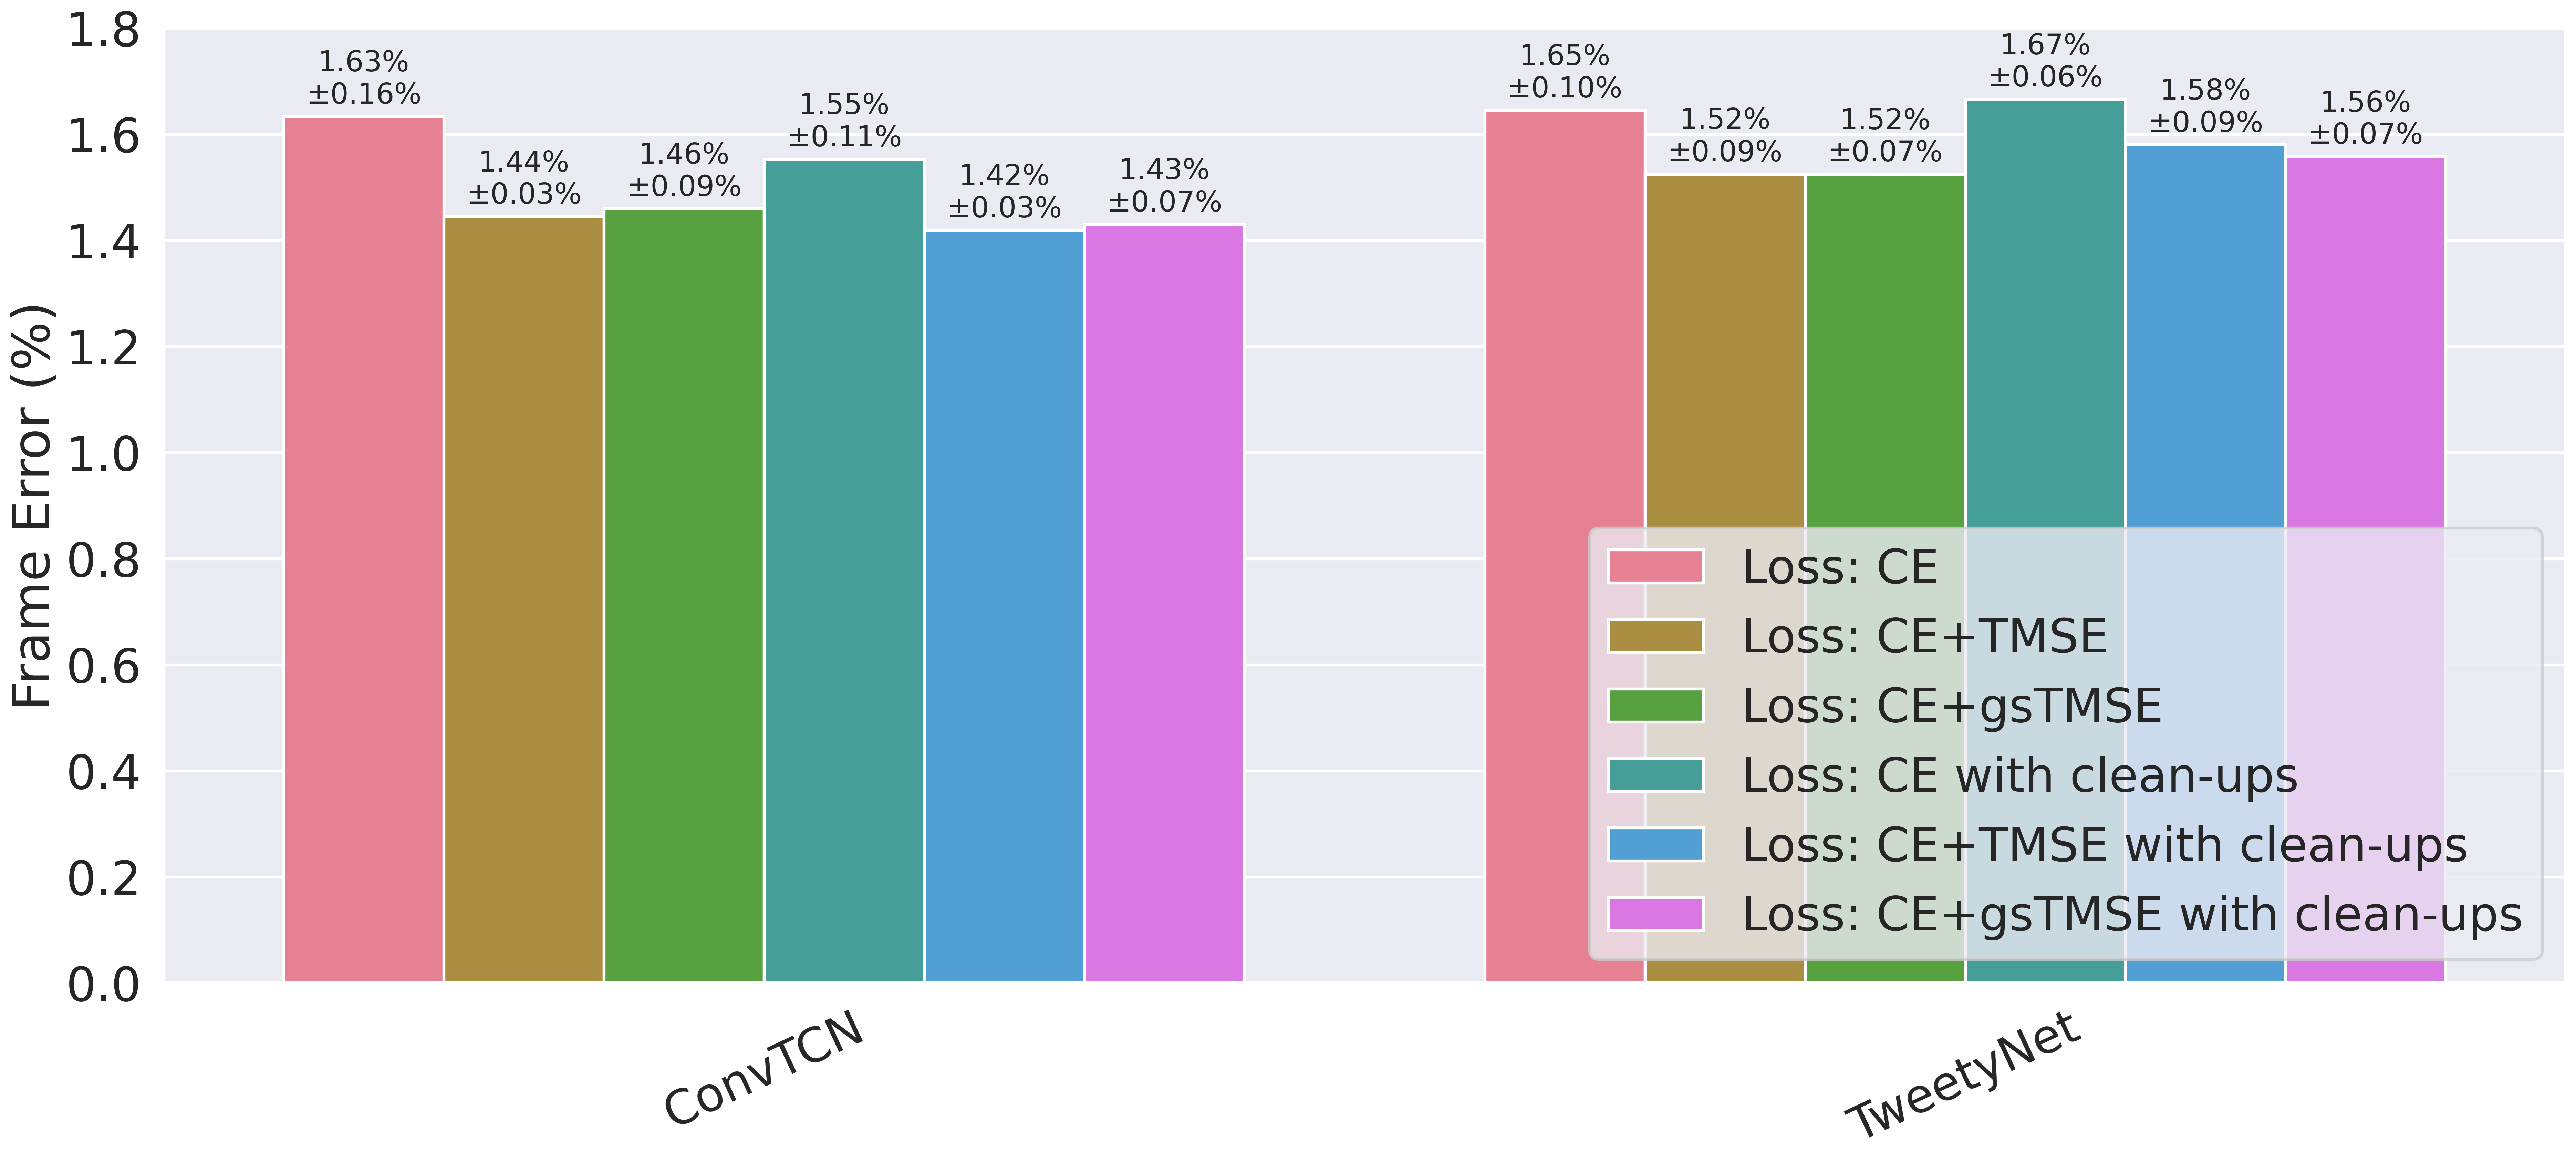

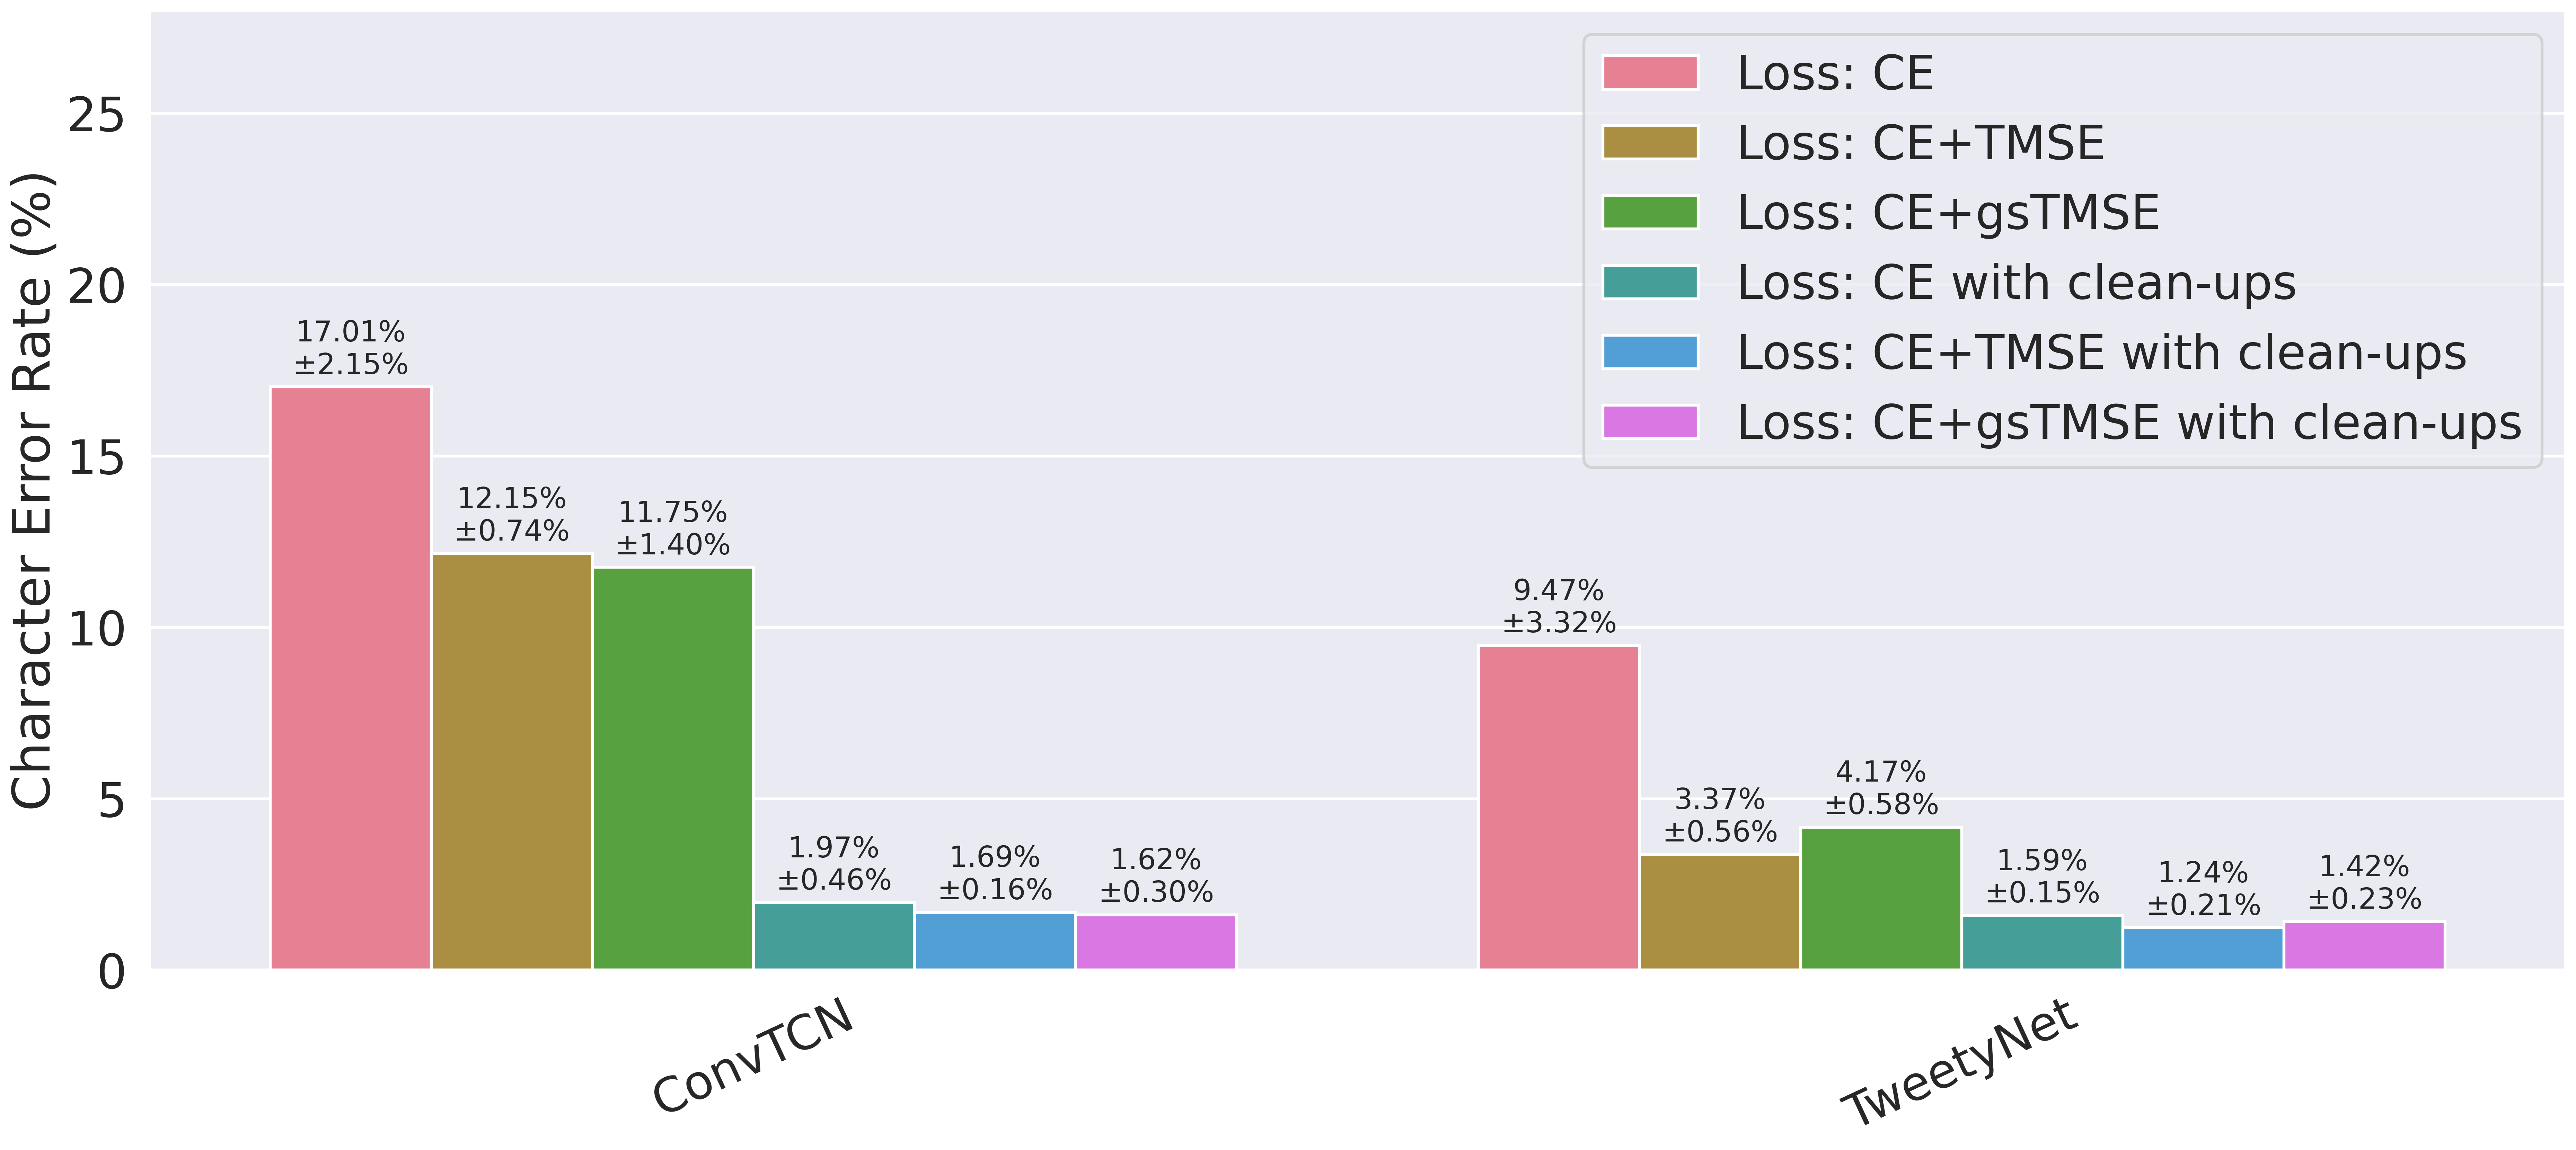

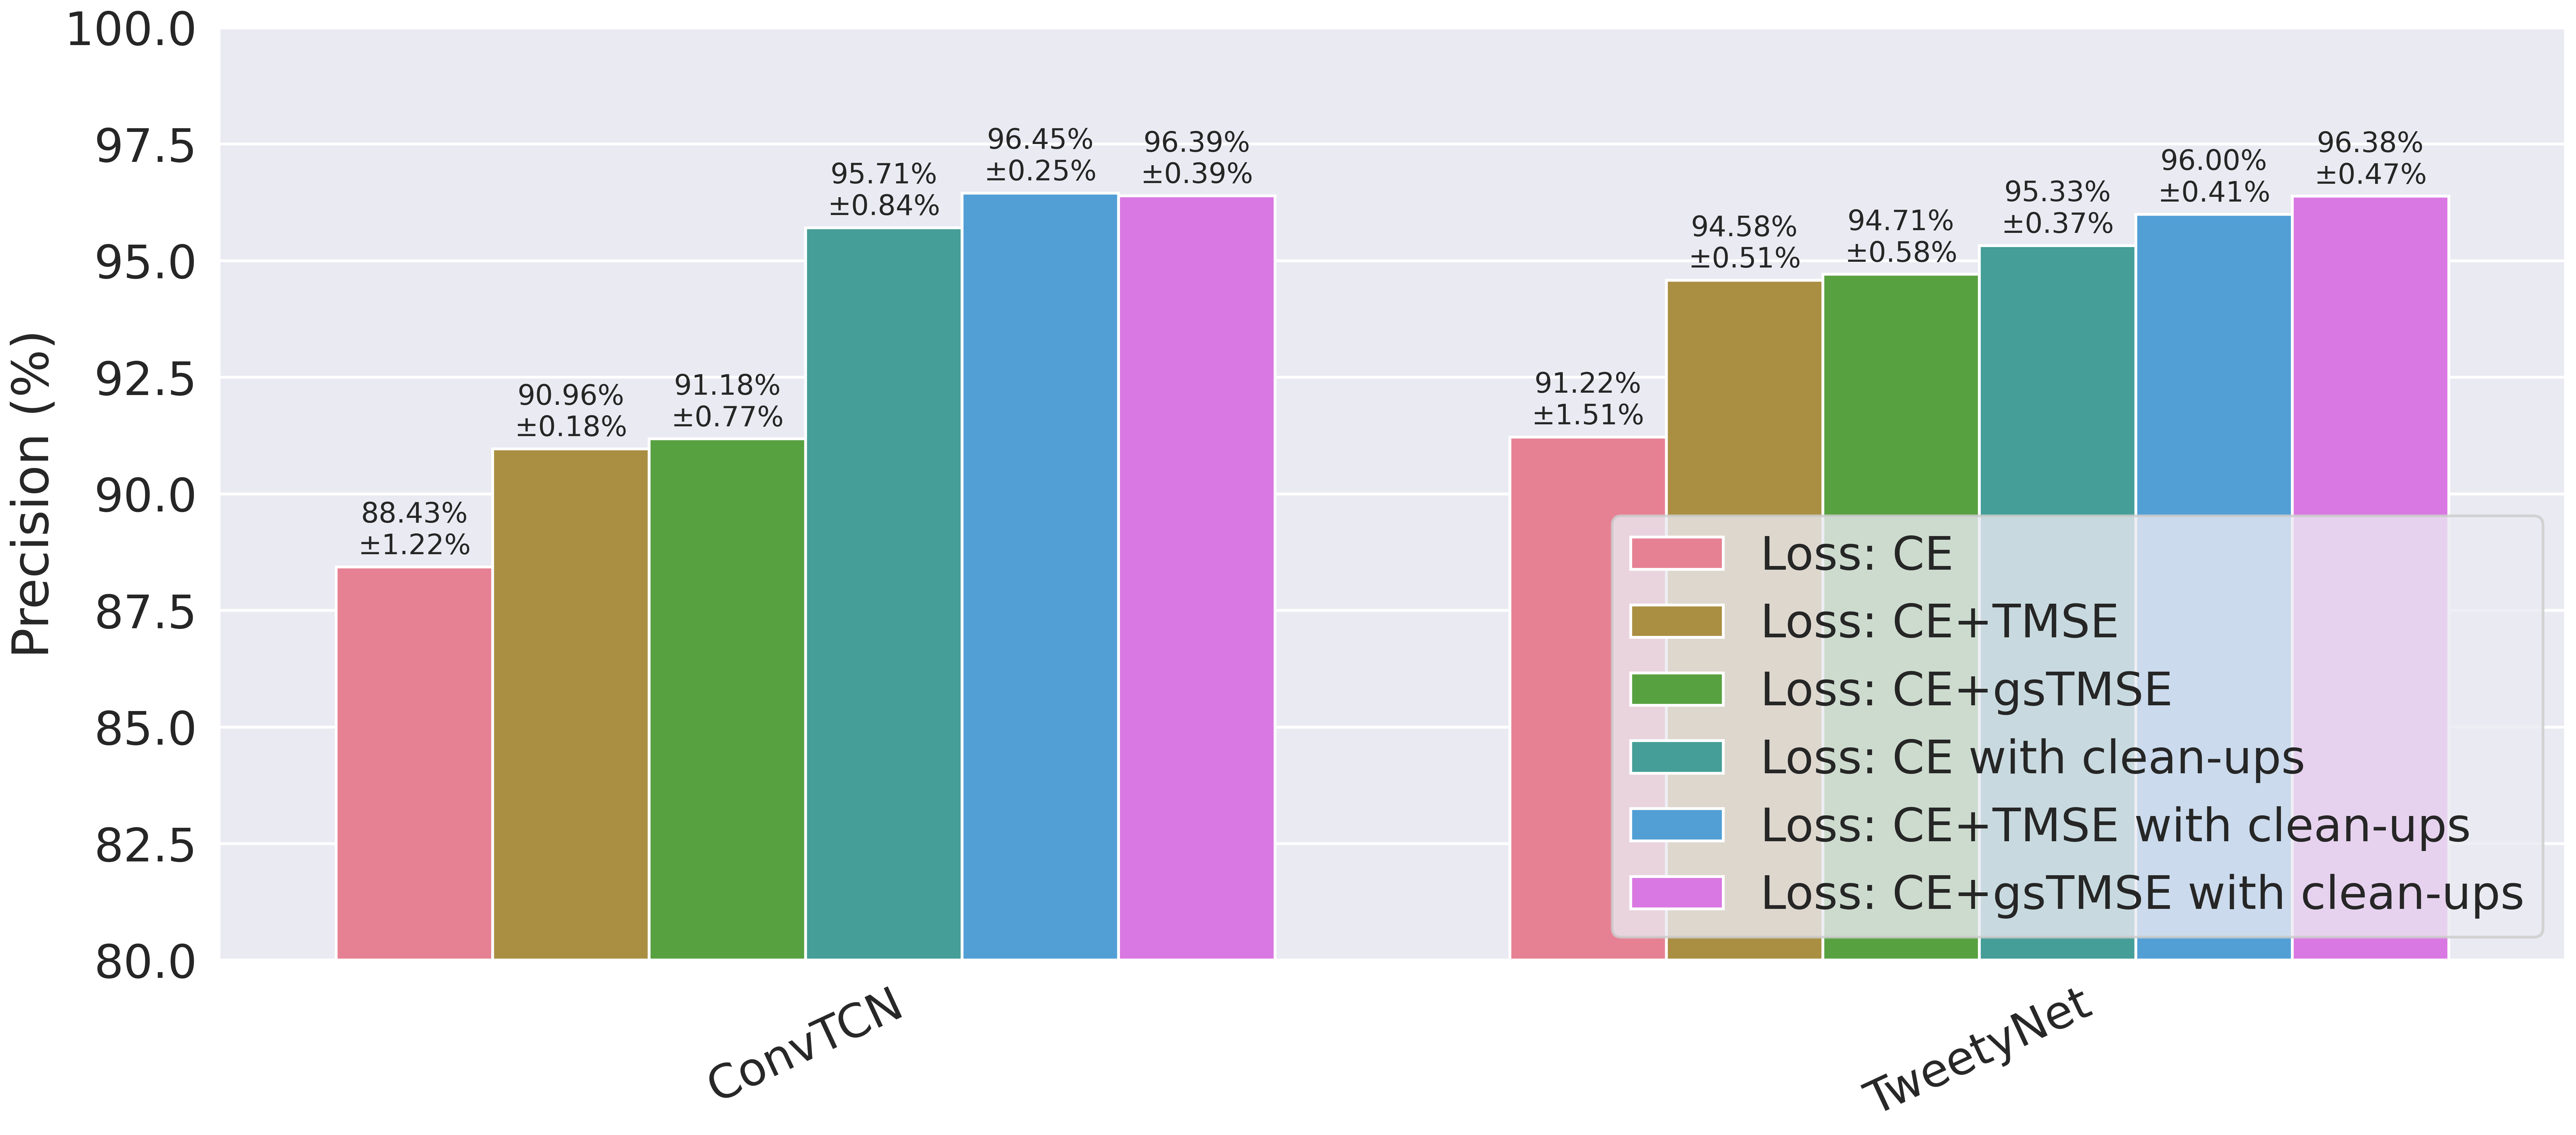

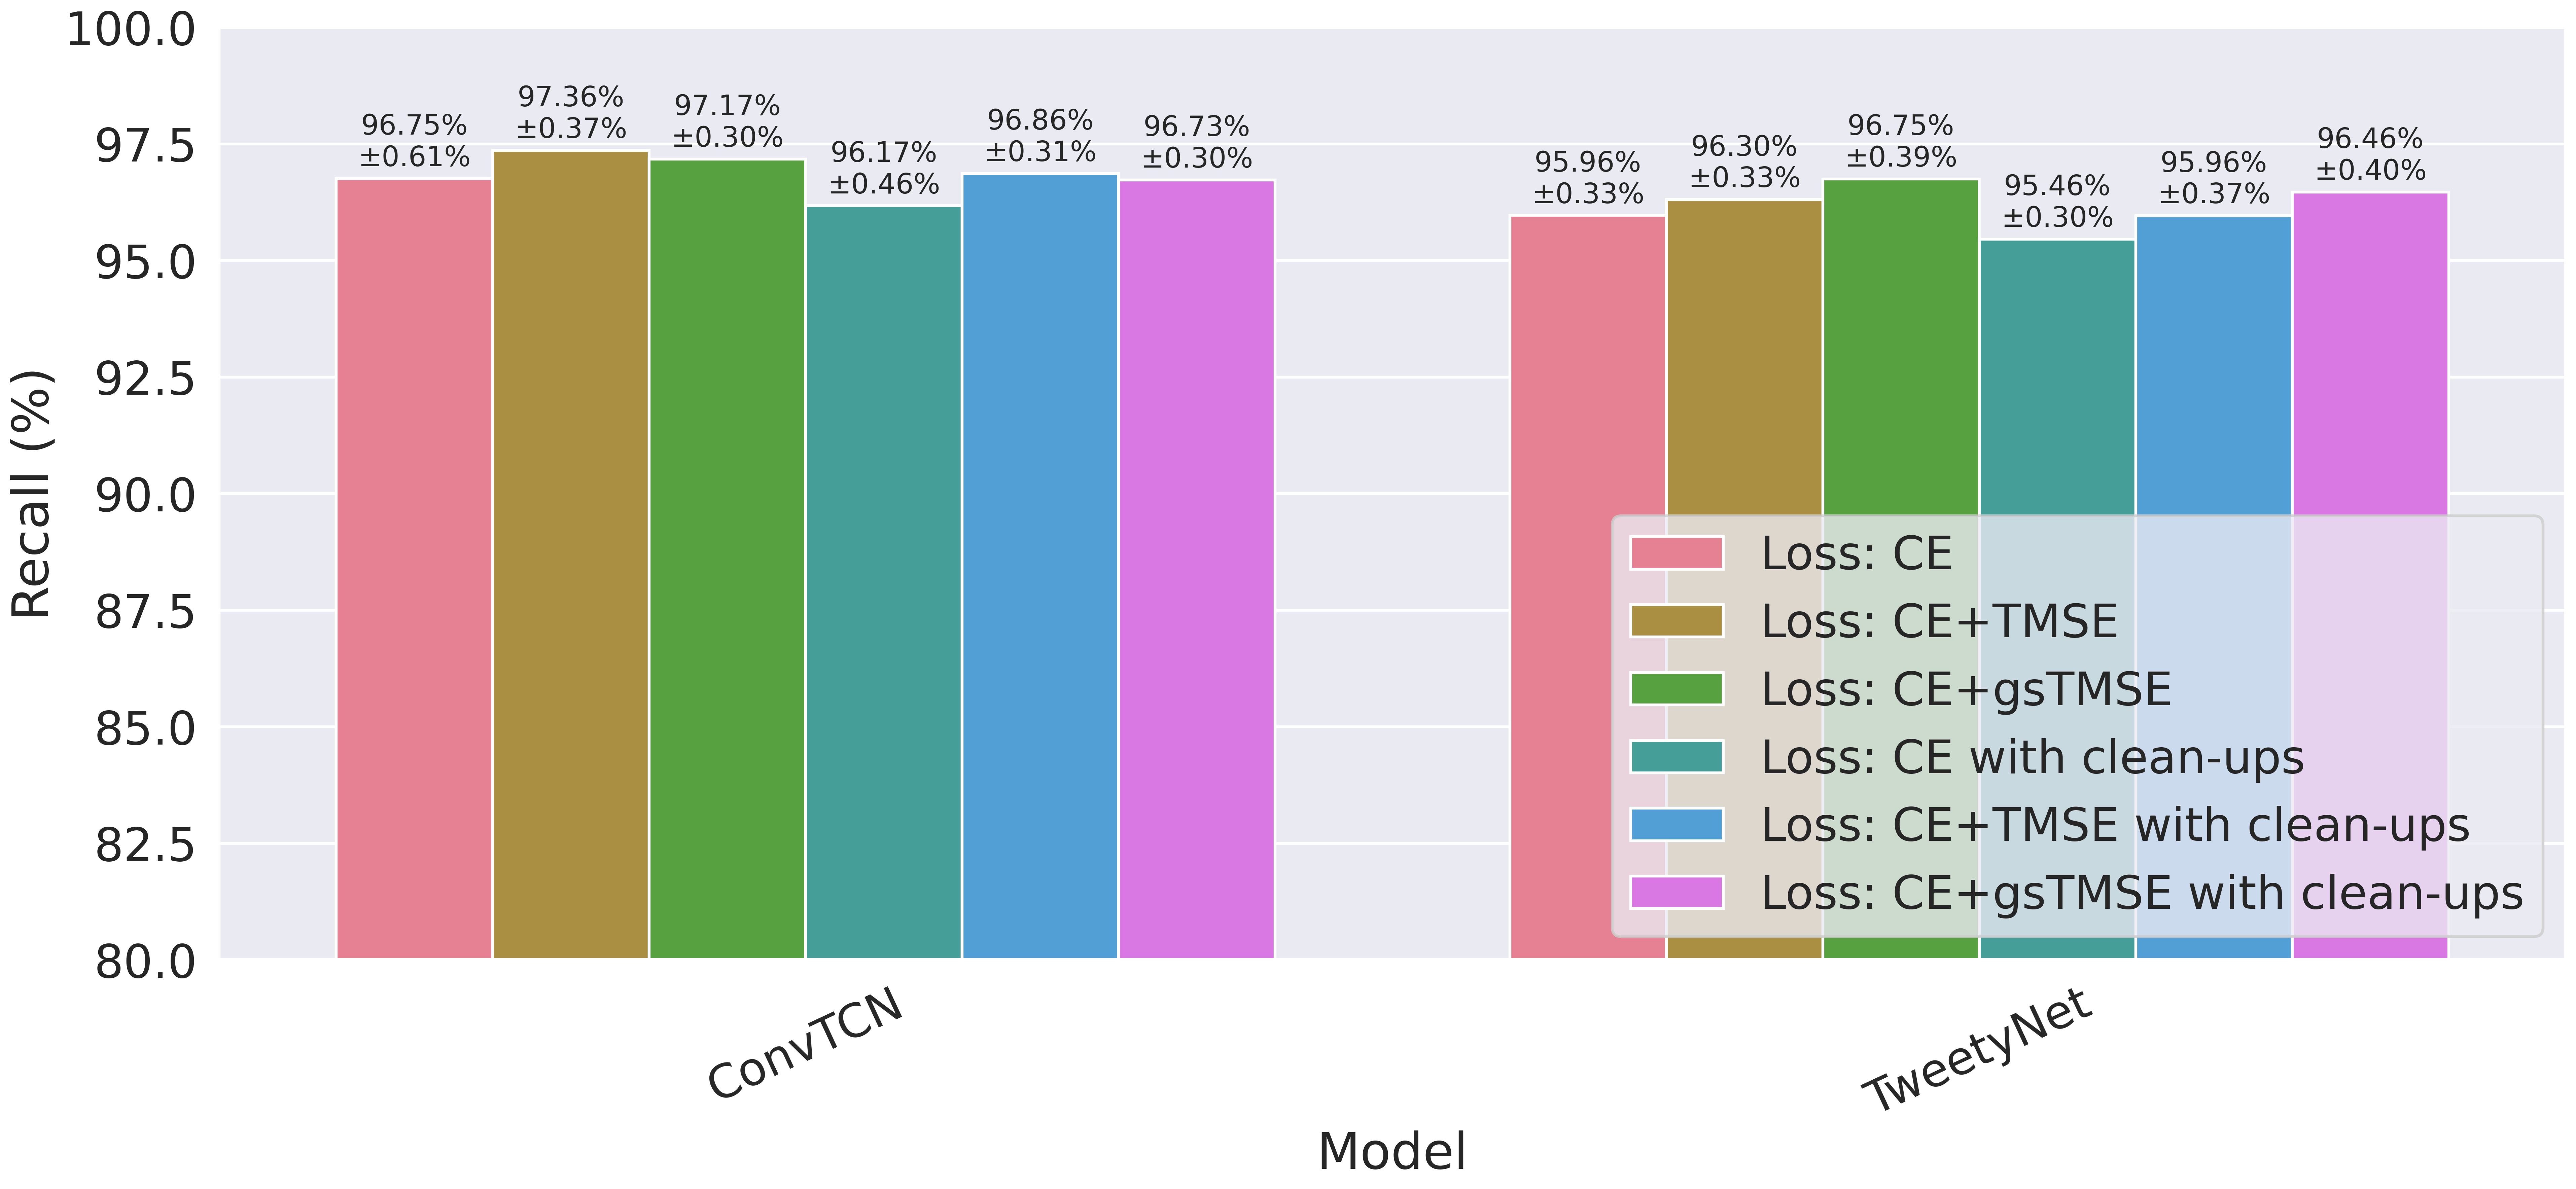

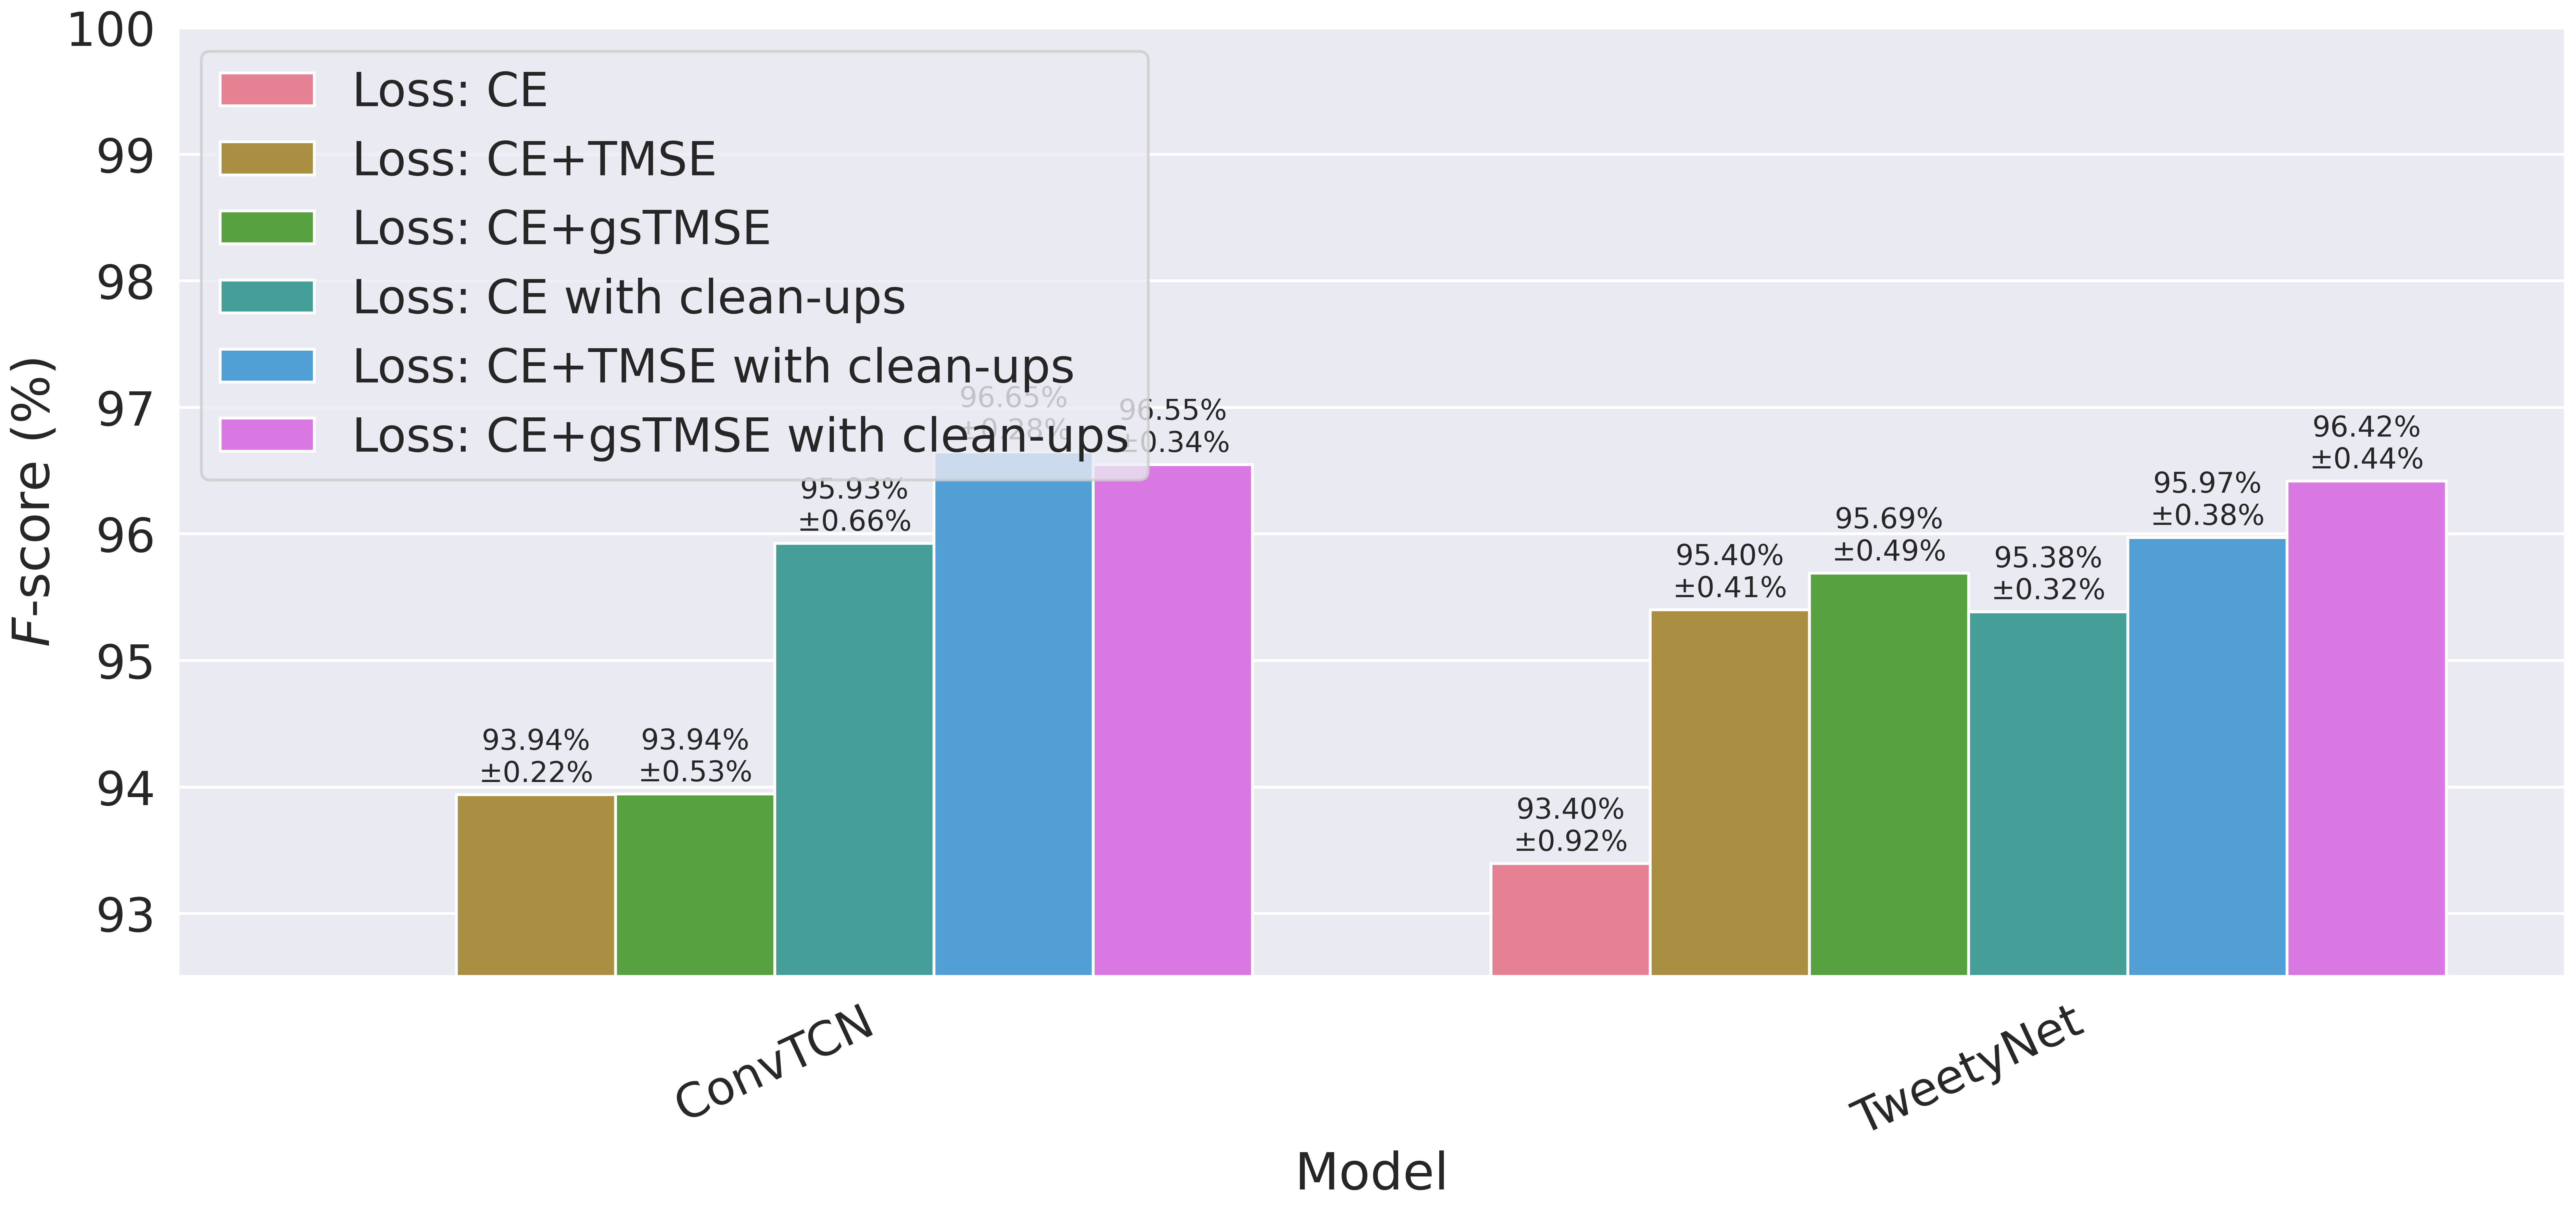

In [8]:
for metrics_plot_num, metrics_plot in enumerate(metrics_plots):
    data_metric = data[data['Metric'] == metrics_plot.metric]
    gb = data_metric.groupby(by=['Model', 'Loss', 'Metric', 'Post-processing']).agg(
        mean=pd.NamedAgg("value", "mean"),
        std=pd.NamedAgg("value", "std"),
    ).reset_index()
    gb = gb.sort_values(by=['Model', 'Post-processing', 'Loss',], ascending=(True, True, True))
    gb['Condition'] = gb.apply(condition, axis=1)
    gb['Model'] = gb['Model'].map(lambda x: x.replace('TemporalConvNet', 'TCN'))

    fig, ax = plt.subplots(1, 1, figsize=(30, 12), dpi=300)
    g = sns.barplot(
        data=gb,
        x='Model',
        y='mean',
        hue='Condition',
        ax=ax,
        palette='husl',
    )
    ax.set_ylabel(metrics_plot.metric)
    ax.tick_params(axis='x', rotation=25)
    ax.set_ylim(metrics_plot.ylim)
    
    for bar, condition_ in zip(ax.containers, gb['Condition'].unique()):
        condition_gb = gb[gb['Condition'] == condition_]
        labels = [f'{mean:.2f}%\n±{std:.2f}%' for mean, std in zip(condition_gb['mean'].values, condition_gb['std'].values)]
        ax.bar_label(
            bar,
            labels=labels,
            padding=5,
            fontsize=20
        )

    # ---- specific stuff for poster
    # don't put legend on CER or precision plot since it blocks other info
    sns.move_legend(ax, loc=metrics_plot.legend_loc)
    # ---- only put 'Model' on bottom plot
    if metrics_plot_num >= len(metrics_plots) - 2:
        pass
    else:
        ax.set_xlabel('')
    g.legend_.set_title(None)
    plt.savefig(f'doc/figures/poster-{metrics_plot.save_fname}.svg', bbox_inches="tight")